In [1]:
import esda
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import libpysal as lps
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
%matplotlib inline

##### 读入面数据

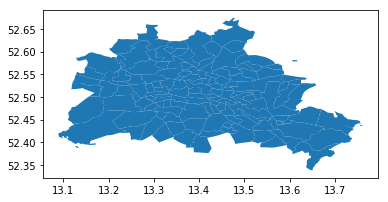

In [2]:
gdf = gpd.read_file('data/berlin-neighbourhoods.geojson')
gdf1 = gpd.read_file('data/berlin-neighbourhoods.geojson')
gdf.plot()

##### 面数据坐标参考系统

In [3]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

##### 面数据表头结构

In [4]:
gdf.head(1)

,neighbourhood,neighbourhood_group,geometry
0,Blankenfelde/Niederschönhausen,Pankow,"MULTIPOLYGON (((13.41191 52.61487, 13.41183 52..."


In [5]:
len(gdf)

140

##### 读入点数据和相关属性信息（pandas）

In [6]:
bl_df = pd.read_csv('data/berlin-listings.csv')

##### 点数据表头结构（96列）

In [7]:
bl_df.head(1)

,Unnamed: 0,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,0,17260587,https://www.airbnb.com/rooms/17260587,20170507222235,2017-05-08,Kunterbuntes Zimmer mit eigenem Bad für jedermann,"Meine Unterkunft ist gut für paare, alleinreis...",NaN,"Meine Unterkunft ist gut für paare, alleinreis...",none,...,10.0,f,NaN,NaN,t,flexible,f,f,3,2.0


In [8]:
len(bl_df)

20053

##### 获取点坐标并构建geometry

In [9]:
geometry = [Point(xy) for xy in zip(bl_df.longitude, bl_df.latitude)]

##### pandas+geometry=geopandas，并将坐标参考系统设置为面相同

In [10]:
#crs = {'init': 'EPSG:4326'} 
bl_gdf = GeoDataFrame(bl_df, crs=gdf.crs, geometry=geometry)

##### 加入geometry后表头结构（97列，geopandas）

In [11]:
bl_gdf.head(1)

,Unnamed: 0,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,...,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,geometry
0,0,17260587,https://www.airbnb.com/rooms/17260587,20170507222235,2017-05-08,Kunterbuntes Zimmer mit eigenem Bad für jedermann,"Meine Unterkunft ist gut für paare, alleinreis...",NaN,"Meine Unterkunft ist gut für paare, alleinreis...",none,...,f,NaN,NaN,t,flexible,f,f,3,2.0,POINT (13.39609 52.58331)


In [12]:
len(bl_gdf)

20053

###### geometry的结构和取值

In [13]:
bl_gdf['geometry'].head(1)

0    POINT (13.39609 52.58331)
Name: geometry, dtype: geometry

###### 使用geopandas直接读取点数据和属性

In [14]:
bl_gdf_d = gpd.read_file('data/berlin-listings.csv')

###### 表头结构（97列，带有geometry属性，但是。。。）

In [15]:
bl_gdf_d.head(1)

,field_1,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,...,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,geometry
0,0,17260587,https://www.airbnb.com/rooms/17260587,20170507222235,2017-05-08,Kunterbuntes Zimmer mit eigenem Bad f眉r jedermann,"Meine Unterkunft ist gut f眉r paare, alleinreis...",,"Meine Unterkunft ist gut f眉r paare, alleinreis...",none,...,f,,,t,flexible,f,f,3,2.0,None


In [16]:
len(bl_gdf_d)

20053

###### 直接读点数据后geometry属性结构和取值，无数据。因此，要么pandas读，然后得到geometry，再组装成geopandas，要么geopandas读，将点坐标组装成geometry赋值给geometry属性

In [17]:
bl_gdf_d['geometry'].head(1)

0    None
Name: geometry, dtype: geometry

##### 获取价格字段数据

In [18]:
bl_gdf['price'].head()

0    30.0
1    17.0
2    50.0
3    28.0
4    21.0
Name: price, dtype: float64

In [19]:
bl_gdf['price'] = bl_gdf['price'].astype('float32')
bl_gdf['price'].head()

0    30.0
1    17.0
2    50.0
3    28.0
4    21.0
Name: price, dtype: float32

##### 将点数据和面数据进行叠加合并（空间连接，即空间叠加，属性表合并）

In [20]:
sj_gdf = gpd.sjoin(gdf, bl_gdf, how='inner', op='intersects', lsuffix='left', rsuffix='right')

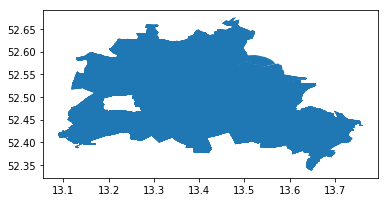

In [21]:
sj_gdf.plot()

In [22]:
sj_gdf.head(1)

,neighbourhood_left,neighbourhood_group,geometry,index_right,Unnamed: 0,id,listing_url,scrape_id,last_scraped,name,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,Blankenfelde/Niederschönhausen,Pankow,"MULTIPOLYGON (((13.41191 52.61487, 13.41183 52...",32,32,15855185,https://www.airbnb.com/rooms/15855185,20170507222235,2017-05-08,Cozy and lovely apartment,...,10.0,f,NaN,NaN,f,moderate,f,f,1,2.13


In [23]:
len(sj_gdf)
sj_gdf.rename(columns={'neighbourhood_left':'neighbourhood'},inplace=True)
sj_gdf.head(1)

,neighbourhood,neighbourhood_group,geometry,index_right,Unnamed: 0,id,listing_url,scrape_id,last_scraped,name,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,Blankenfelde/Niederschönhausen,Pankow,"MULTIPOLYGON (((13.41191 52.61487, 13.41183 52...",32,32,15855185,https://www.airbnb.com/rooms/15855185,20170507222235,2017-05-08,Cozy and lovely apartment,...,10.0,f,NaN,NaN,f,moderate,f,f,1,2.13


##### 按区域分组并求区域价格均值

In [24]:
median_price_gb = sj_gdf['price'].groupby([sj_gdf['neighbourhood_group']]).mean()
median_price_area=sj_gdf['price'].groupby([sj_gdf['neighbourhood']]).mean()

median_price_gb
median_price_area

neighbourhood
Adlershof                43.388889
Albrechtstr.             43.763439
Alexanderplatz           75.085197
Allende-Viertel          38.666668
Alt  Treptow             51.055557
                           ...    
Wilhelmstadt             49.333332
Zehlendorf  Nord         66.400002
Zehlendorf  Südwest      61.000000
nördliche Luisenstadt    60.365425
südliche Luisenstadt     57.453056
Name: price, Length: 137, dtype: float32

In [25]:
len(median_price_gb)
len(median_price_area)

137

In [26]:
type(median_price_gb)
type(median_price_area)

pandas.core.series.Series

In [27]:
median_price_gb.head(1)
median_price_area.head(1)

neighbourhood
Adlershof    43.388889
Name: price, dtype: float32

###### 将面图层与区域价格均值按照区域进行属性表连接，属性链接

In [28]:
gdf = gdf.join(median_price_gb, on='neighbourhood_group')
gdf.head(1)

,neighbourhood,neighbourhood_group,geometry,price
0,Blankenfelde/Niederschönhausen,Pankow,"MULTIPOLYGON (((13.41191 52.61487, 13.41183 52...",60.282516


In [29]:
gdf1 = gdf1.join(median_price_area, on='neighbourhood')
gdf1.head(1)

,neighbourhood,neighbourhood_group,geometry,price
0,Blankenfelde/Niederschönhausen,Pankow,"MULTIPOLYGON (((13.41191 52.61487, 13.41183 52...",47.238094


###### 更改列名

In [30]:
gdf.rename(columns={'price': 'median_pri'}, inplace=True)
gdf.head(1)

,neighbourhood,neighbourhood_group,geometry,median_pri
0,Blankenfelde/Niederschönhausen,Pankow,"MULTIPOLYGON (((13.41191 52.61487, 13.41183 52...",60.282516


In [31]:
gdf1.rename(columns={'price': 'median_pri'}, inplace=True)
gdf1.head(1)

,neighbourhood,neighbourhood_group,geometry,median_pri
0,Blankenfelde/Niederschönhausen,Pankow,"MULTIPOLYGON (((13.41191 52.61487, 13.41183 52...",47.238094


In [32]:
len(gdf)

140

In [33]:
len(gdf1)

140

###### 查看空值个数

In [34]:
# gdf.drop(axis=1,columns=['median_pri'],inplace=True)
# gdf.head(1)

pd.isnull(gdf['median_pri']).sum()

2

In [35]:
pd.isnull(gdf1['median_pri']).sum()

3

###### 用均值填充空值

In [36]:
gdf['median_pri'].fillna((gdf['median_pri'].mean()), inplace=True)
gdf1['median_pri'].fillna((gdf1['median_pri'].mean()), inplace=True)

In [37]:
pd.isnull(gdf1['median_pri']).sum()

0

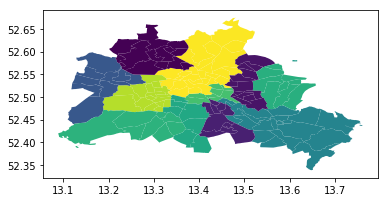

In [38]:
gdf.plot(column='median_pri')

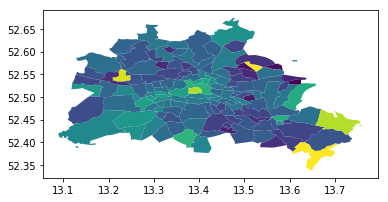

In [39]:
gdf1.plot(column='median_pri')

###### 按数量级分为5个类显示

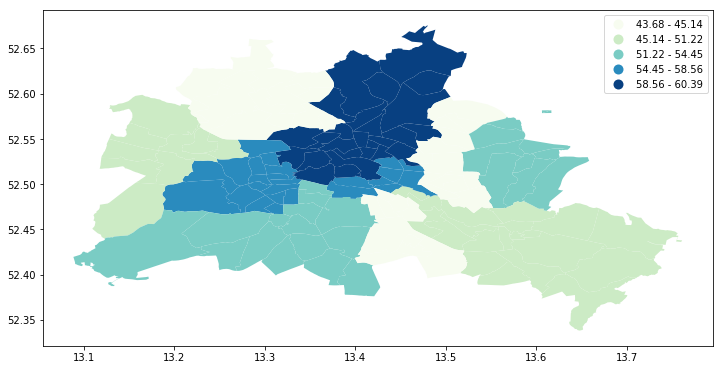

In [40]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
gdf.plot(column='median_pri', scheme='Quantiles', k=5, cmap='GnBu', legend=True, ax=ax)

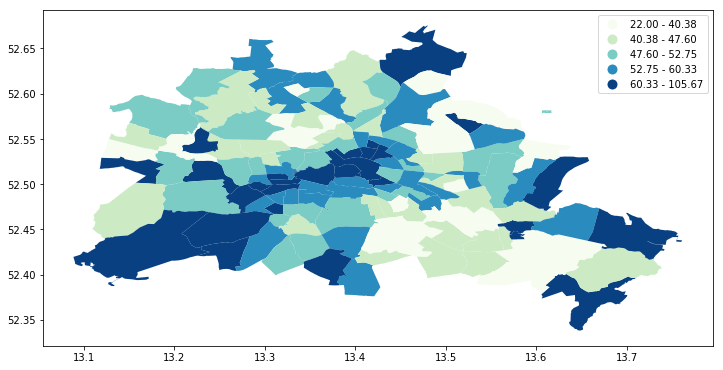

In [41]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
gdf1.plot(column='median_pri', scheme='Quantiles', k=5, cmap='GnBu', legend=True, ax=ax)

###### 创建rook邻接矩阵，并进行行归一化（莫兰指数要求）
! [地理学定理](地理学定理.png)
! [空间自相关1](空间自相关-空间.png)
! [空间自相关2](空间自相关-属性.png)
! [权重矩阵类型](权重矩阵.png)
! [权重矩阵](权重矩阵1.png)
! [邻接矩阵](邻接矩阵.png)

In [42]:
df = gdf
wq =  lps.weights.Rook.from_dataframe(df)
wq.transform = 'r'

c:\users\lenovo\appdata\local\programs\python\python37\lib\site-packages\libpysal\weights\weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


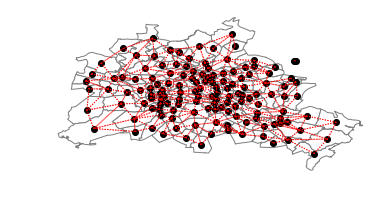

In [43]:
ax = df.plot(edgecolor='grey', facecolor='w')
f,ax = wq.plot(df, ax=ax,
        edge_kws=dict(color='r', linestyle=':', linewidth=1),
        node_kws=dict(marker='o'))
ax.set_axis_off()

###### 显示相邻情况

In [44]:
wq.neighbors

{0: [9, 25, 29, 14, 31],
 1: [34, 35, 38, 39],
 2: [50, 45, 43, 59, 61],
 3: [74, 4],
 4: [82, 3, 76, 74],
 5: [84, 100, 134, 10, 91, 79],
 6: [92, 14, 94, 7],
 7: [96, 115, 6, 106, 92, 94],
 8: [24, 89, 107, 37],
 9: [0, 25, 26, 28],
 10: [5, 134, 135, 136, 79],
 11: [12],
 12: [11],
 13: [98, 15, 21, 23],
 14: [0, 6, 105, 138, 139, 29, 94, 95],
 15: [98, 38, 39, 13, 111, 112, 113, 16, 19, 21, 24],
 16: [113, 34, 38, 15],
 17: [113, 18, 19, 36, 20, 103, 30],
 18: [17, 110, 20, 113],
 19: [17, 113, 103, 15, 111],
 20: [36, 137, 106, 138, 110, 17, 18, 95],
 21: [112, 22, 23, 111, 13, 15],
 22: [78, 111, 23, 21, 118, 119, 120, 121],
 23: [21, 22, 78, 107, 13, 62],
 24: [98, 37, 39, 8, 15],
 25: [0, 9, 28, 31],
 26: [9, 28],
 27: [32, 33, 35, 83, 37, 88, 28],
 28: [32, 33, 9, 80, 85, 25, 26, 27, 31],
 29: [0, 105, 14, 137, 138, 110, 31],
 30: [17, 36, 41, 103],
 31: [0, 32, 34, 25, 28, 29, 110],
 32: [34, 35, 27, 28, 31],
 33: [80, 87, 88, 27, 28],
 34: [32, 1, 35, 38, 110, 16, 113, 31],


In [45]:
wq.histogram

[(1, 2),
 (2, 5),
 (3, 15),
 (4, 31),
 (5, 28),
 (6, 24),
 (7, 22),
 (8, 9),
 (9, 2),
 (10, 1),
 (11, 1)]

##### 创建空间滞后项

In [46]:
y = df['median_pri']
ylag = lps.weights.lag_spatial(wq, y)
ylag

array([56.9625061 , 60.28251648, 55.94171753, 51.22200394, 51.22200394,
       50.52180099, 43.6824646 , 45.20049667, 53.96310139, 60.28251648,
       53.64180374, 52.73586273, 52.73586273, 56.71657944, 47.83247757,
       58.58870177, 60.33520317, 59.60296903, 60.38788986, 60.02159348,
       51.80624199, 57.94034958, 52.84482813, 53.05486488, 58.38770828,
       60.28251648, 60.28251648, 55.79730334, 56.79401737, 50.81182589,
       59.01427841, 60.29756982, 60.28251648, 50.86356888, 60.3220315 ,
       60.28251648, 55.48057556, 54.42881557, 60.32466583, 59.50179418,
       54.42846909, 58.55640793, 58.55640793, 57.52872658, 57.8632649 ,
       58.55640793, 56.13040733, 48.23656082, 48.23656082, 53.74621709,
       55.11957245, 46.71852875, 51.67650986, 54.1985906 , 51.45368042,
       52.36880302, 54.44568253, 54.44568253, 50.84825389, 56.50104523,
       53.92108345, 55.5688324 , 50.49590378, 49.14499828, 48.61369433,
       49.70049   , 49.32550866, 51.22200394, 51.22200394, 47.80

In [47]:
ylag.shape

(140,)

##### 将空间滞后项添加为一列，并同时显示价格和价格滞后项

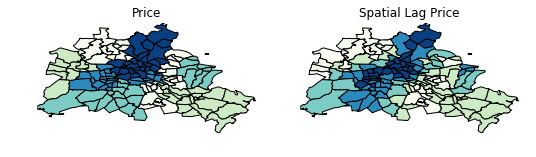

In [48]:
df['lag_median_pri'] = ylag
f,ax = plt.subplots(1,2,figsize=(2.16*4,4))
df.plot(column='median_pri', ax=ax[0], edgecolor='k',
        scheme="quantiles",  k=5, cmap='GnBu')
ax[0].axis(df.total_bounds[np.asarray([0,2,1,3])])
ax[0].set_title("Price")
df.plot(column='lag_median_pri', ax=ax[1], edgecolor='k',
        scheme='quantiles', cmap='GnBu', k=5)
ax[1].axis(df.total_bounds[np.asarray([0,2,1,3])])
ax[1].set_title("Spatial Lag Price")
ax[0].axis('off')
ax[1].axis('off')
plt.show()

In [49]:
df1 = gdf1
wq1 =  lps.weights.Queen.from_dataframe(df1)
wq1.transform = 'r'

c:\users\lenovo\appdata\local\programs\python\python37\lib\site-packages\libpysal\weights\weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


In [50]:
y1 = df1['median_pri']
ylag1 = lps.weights.lag_spatial(wq1, y1)
ylag1

array([53.965065  , 61.73417854, 54.87606621, 40.85000038, 69.59244823,
       48.27040418, 47.12088776, 54.46856744, 51.8315436 , 48.08876991,
       46.64263763, 51.64567947, 51.64567947, 59.27816696, 44.59299612,
       63.32851271, 63.71773148, 46.62795912, 45.19522667, 59.56215591,
       41.85445738, 69.11469332, 55.32438993, 54.63037436, 58.26648394,
       54.75248718, 61.00640869, 47.18332618, 44.16120487, 46.36773954,
       49.28781223, 50.31800788, 54.33884659, 41.13860359, 56.1181078 ,
       56.96051661, 47.00043924, 51.78949247, 66.6368927 , 62.67118454,
       50.2536972 , 53.04295222, 60.95234823, 63.02506866, 60.32661523,
       58.47154935, 56.45957883, 48.21527672, 43.71483994, 58.07568741,
       55.78141327, 42.66110992, 49.15550931, 50.68949   , 54.77948685,
       57.05725288, 62.22857157, 54.82718582, 58.21178309, 58.67643785,
       55.98174953, 52.68479701, 51.44391479, 47.03782272, 43.45044926,
       40.19673824, 50.72758647, 57.38392544, 48.56441625, 38.33

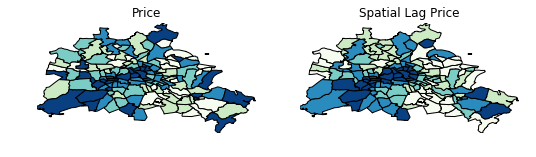

In [51]:
df1['lag_median_pri'] = ylag1
f,ax = plt.subplots(1,2,figsize=(2.16*4,4))
df1.plot(column='median_pri', ax=ax[0], edgecolor='k',
        scheme="quantiles",  k=5, cmap='GnBu')
ax[0].axis(df1.total_bounds[np.asarray([0,2,1,3])])
ax[0].set_title("Price")
df1.plot(column='lag_median_pri', ax=ax[1], edgecolor='k',
        scheme='quantiles', cmap='GnBu', k=5)
ax[1].axis(df1.total_bounds[np.asarray([0,2,1,3])])
ax[1].set_title("Spatial Lag Price")
ax[0].axis('off')
ax[1].axis('off')
plt.show()

In [52]:
y.median()

53.704407

In [53]:
y1.median()

50.10517

In [54]:
yb = y > y.median()
sum(yb)

68

In [55]:
yb1 = y1 > y1.median()
sum(yb1)

70

##### 黑白显示大于中值和小于中值结果

In [56]:
labels = ["0 Low", "1 High"]
yb = [labels[i] for i in 1*yb] 
df['yb'] = yb

In [57]:
labels = ["0 Low", "1 High"]
yb1 = [labels[i] for i in 1*yb1] 
df1['yb'] = yb1

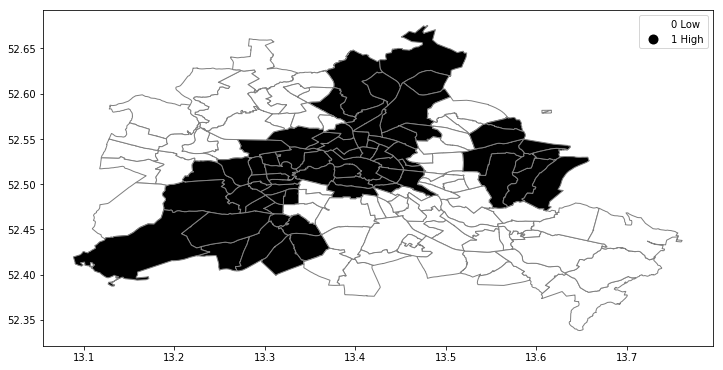

In [58]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
df.plot(column='yb', cmap='binary', edgecolor='grey', legend=True, ax=ax)

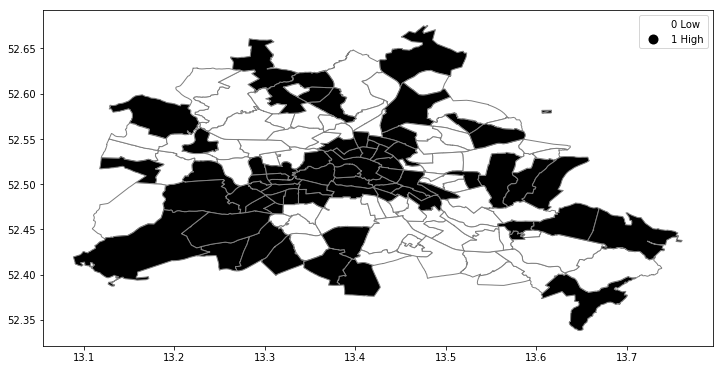

In [59]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
df1.plot(column='yb', cmap='binary', edgecolor='grey', legend=True, ax=ax)

##### 利用邻接矩阵计算全局莫兰指数

In [60]:
mi = esda.moran.Moran(y, wq)
mi.I

0.6578173309908556

In [61]:
mi1 = esda.moran.Moran(y1, wq1)
mi1.I

0.12373909942754366

##### 莫兰指数显著性

In [62]:
mi.p_sim

0.001

In [63]:
mi1.p_sim

0.012

##### Z值

In [64]:
mi.z_sim

12.669432502652693

In [65]:
mi1.z_sim

2.5523740145558502

In [66]:
wq.transform = 'r'
lag_price = lps.weights.lag_spatial(wq, df['median_pri'])

### 莫兰指数就是价格和空间滞后价格的直线拟合系数（OLS线性回归系数）

In [67]:
price = df['median_pri']
b, a = np.polyfit(price, lag_price, 1)

In [68]:
print(b,a)

0.6578173884192813 18.185694777863326


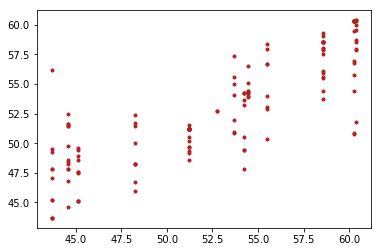

In [69]:
plt.plot(price, lag_price, '.', color='firebrick')

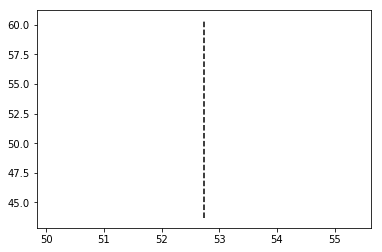

In [70]:
plt.vlines(price.mean(), lag_price.min(), lag_price.max(), linestyle='--')

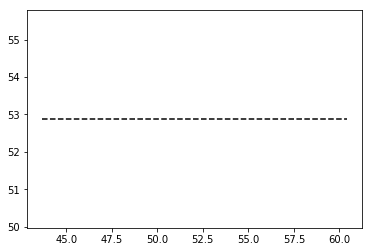

In [71]:
plt.hlines(lag_price.mean(), price.min(), price.max(), linestyle='--')

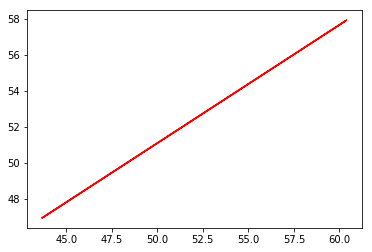

In [72]:
plt.plot(price, a + b*price, 'r')

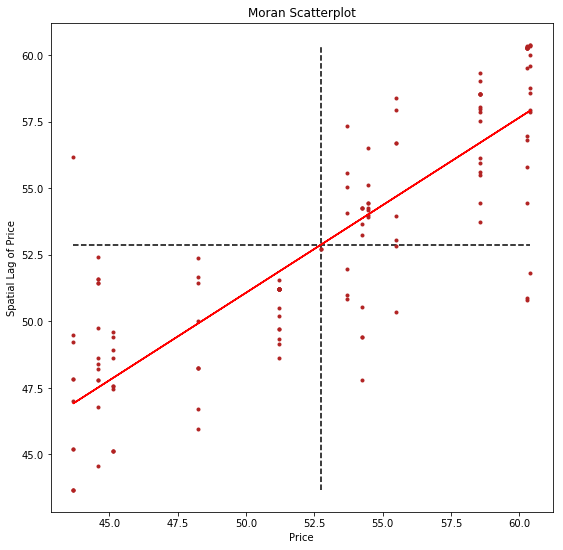

In [73]:
price = df['median_pri']
b, a = np.polyfit(price, lag_price, 1)
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(price, lag_price, '.', color='firebrick')

 # dashed vert at mean of the price
plt.vlines(price.mean(), lag_price.min(), lag_price.max(), linestyle='--')
 # dashed horizontal at mean of lagged price 
plt.hlines(lag_price.mean(), price.min(), price.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(price, a + b*price, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Price')
plt.xlabel('Price')
plt.show()

In [74]:
wq1.transform = 'r'
lag_price1 = lps.weights.lag_spatial(wq1, df1['median_pri'])

In [75]:
price1 = df1['median_pri']
b1, a1 = np.polyfit(price1, lag_price1, 1)

In [76]:
print(b1,a1)

0.12373910034297503 44.72079904930634


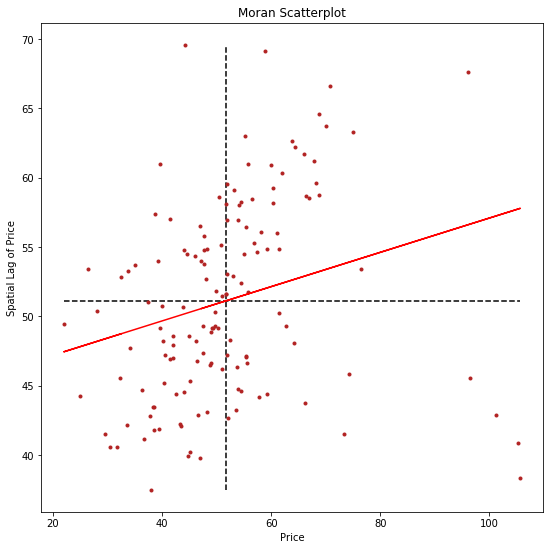

In [77]:
price1 = df1['median_pri']
b1, a1 = np.polyfit(price1, lag_price1, 1)
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(price1, lag_price1, '.', color='firebrick')

 # dashed vert at mean of the price
plt.vlines(price1.mean(), lag_price1.min(), lag_price1.max(), linestyle='--')
 # dashed horizontal at mean of lagged price 
plt.hlines(lag_price1.mean(), price1.min(), price1.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(price1, a1 + b1*price1, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Price')
plt.xlabel('Price')
plt.show()

## 莫兰指数较大，具有空间相关性，使用局部莫兰指数测试空间相关程度（情况）

In [78]:
li = esda.moran.Moran_Local(y, wq)

c:\users\lenovo\appdata\local\programs\python\python37\lib\site-packages\esda\moran.py:886: RuntimeWarning: invalid value encountered in true_divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
c:\users\lenovo\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1847: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0


In [79]:
li.q

array([1, 1, 1, 3, 3, 4, 3, 3, 1, 1, 1, 3, 3, 1, 3, 1, 1, 1, 1, 1, 4, 1,
       1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 3, 3, 1, 1, 3, 3, 1, 3, 3, 1, 1, 4, 1, 1, 1, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 1, 1, 1, 3, 3, 4, 3, 1,
       1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 4, 3, 4, 1, 3, 3, 3, 3, 3, 4, 3, 3,
       4, 1, 1, 1, 1, 2, 3, 3])

In [80]:
li1 = esda.moran.Moran_Local(y1, wq1)

In [81]:
li1.q

array([2, 1, 1, 4, 2, 4, 4, 2, 2, 4, 4, 3, 3, 1, 4, 1, 1, 3, 3, 1, 3, 1,
       1, 1, 1, 2, 2, 4, 4, 4, 3, 3, 2, 3, 1, 1, 3, 1, 1, 1, 4, 1, 1, 1,
       1, 1, 1, 3, 4, 2, 2, 4, 3, 3, 2, 2, 1, 1, 1, 1, 1, 2, 3, 4, 3, 3,
       3, 2, 3, 4, 3, 3, 3, 3, 3, 4, 2, 4, 3, 2, 2, 1, 4, 3, 3, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 1, 2, 1, 4, 3, 1, 1, 1, 3, 3, 1, 4, 2,
       3, 1, 1, 2, 3, 2, 2, 1, 1, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3,
       4, 3, 3, 3, 4, 3, 3, 2])

#### 具有95%置信度统计显著性元素个数

In [82]:
(li.p_sim < 0.05).sum()

64

In [83]:
(li1.p_sim < 0.05).sum()

28

## 分别按照四个象限展示冷热点和异常点
! [局部莫兰指数](局部莫兰指数.png)

In [84]:
sig = li.p_sim < 0.05
hotspot = sig * li.q==1
coldspot = sig * li.q==3
doughnut = sig * li.q==2
diamond = sig * li.q==4

In [85]:
spots = ['n.sig.', 'hot spot']
labels = [spots[i] for i in hotspot*1]

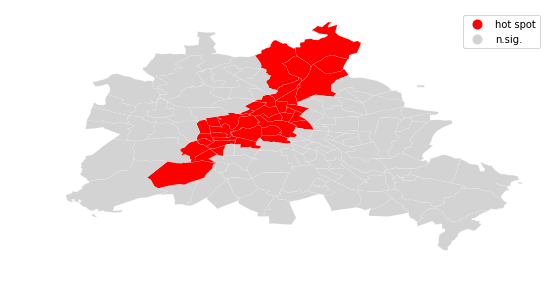

In [86]:
df = df
from matplotlib import colors
hmap = colors.ListedColormap(['red', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

In [87]:
sig1 = li1.p_sim < 0.05
hotspot1 = sig1 * li1.q==1
coldspot1 = sig1 * li1.q==3
doughnut1 = sig1 * li1.q==2
diamond1 = sig1 * li1.q==4

In [88]:
spots = ['n.sig.', 'hot spot']
labels1 = [spots[i] for i in hotspot1*1]

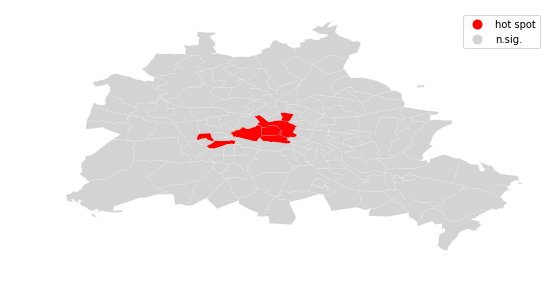

In [89]:
df = df1
from matplotlib import colors
hmap = colors.ListedColormap(['red', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels1).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

In [90]:
sig = 1 * (li.p_sim < 0.05)
hotspot = 1 * (sig * li.q==1)
coldspot = 3 * (sig * li.q==3)
doughnut = 2 * (sig * li.q==2)
diamond = 4 * (sig * li.q==4)
spots = hotspot + coldspot + doughnut + diamond
spots

array([1, 1, 0, 0, 0, 0, 3, 3, 0, 1, 0, 3, 3, 0, 3, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 3, 3, 0,
       0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 3, 0,
       0, 0, 0, 3, 3, 3, 3, 3, 3, 1, 0, 1, 3, 3, 1, 1, 1, 3, 0, 0, 3, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 3, 0, 3, 3, 3, 0, 0, 0,
       4, 0, 0, 0, 0, 0, 0, 3])

In [91]:
spot_labels = [ '0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots]

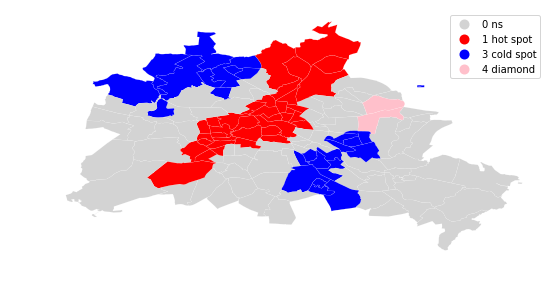

In [92]:
from matplotlib import colors
hmap = colors.ListedColormap([ 'lightgrey', 'red', 'lightblue', 'blue', 'pink'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

In [93]:
sig1 = 1 * (li1.p_sim < 0.05)
hotspot1 = 1 * (sig1 * li1.q==1)
coldspot1 = 3 * (sig1 * li1.q==3)
doughnut1 = 2 * (sig1 * li1.q==2)
diamond1 = 4 * (sig1 * li1.q==4)
spots1 = hotspot1 + coldspot1 + doughnut1 + diamond1
spots1

array([0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 1, 0, 0, 0, 0, 3, 1,
       0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 3, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3,
       0, 0, 0, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3,
       3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 3, 0, 0, 3,
       4, 3, 3, 0, 0, 0, 0, 0])

In [94]:
spot_labels1 = [ '0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels1 = [spot_labels1[i] for i in spots1]

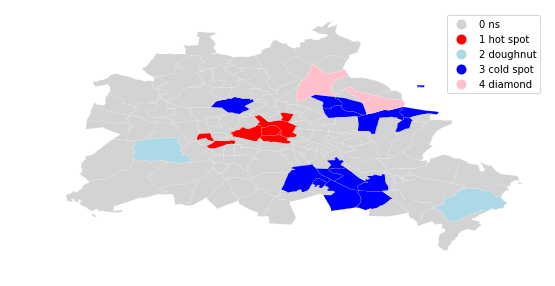

In [95]:
from matplotlib import colors
hmap = colors.ListedColormap([ 'lightgrey', 'red', 'lightblue', 'blue', 'pink'])
f, ax = plt.subplots(1, figsize=(9, 9))
df1.assign(cl=labels1).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

##### 使用莫兰散点图对象绘制全局莫兰散点图

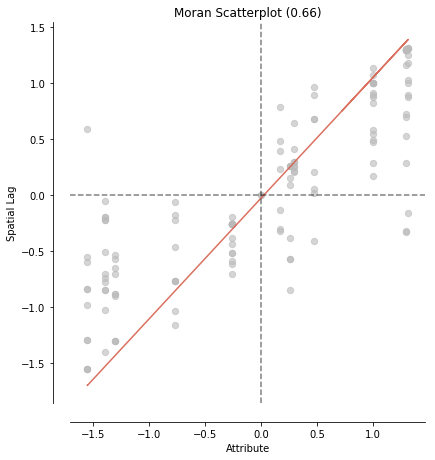

In [96]:
from splot.esda import moran_scatterplot

fig, ax = moran_scatterplot(mi)
plt.show()

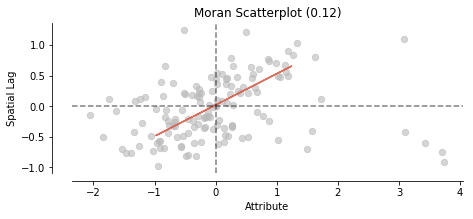

In [97]:
fig, ax = moran_scatterplot(mi1)


### 使用莫兰散点图对象绘制局部莫兰散点图

c:\users\lenovo\appdata\local\programs\python\python37\lib\site-packages\esda\moran.py:886: RuntimeWarning: invalid value encountered in true_divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
c:\users\lenovo\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1847: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0


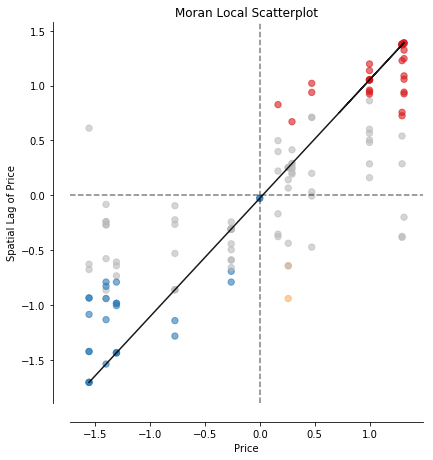

In [98]:
from splot.esda import moran_scatterplot
from esda.moran import Moran_Local

# calculate Moran_Local and plot
moran_loc = esda.moran.Moran_Local(y, wq)
fig, ax = moran_scatterplot(moran_loc, p=0.05)
ax.set_xlabel('Price')
ax.set_ylabel('Spatial Lag of Price')
plt.show()

Text(0,0.5,'Spatial Lag of Price')

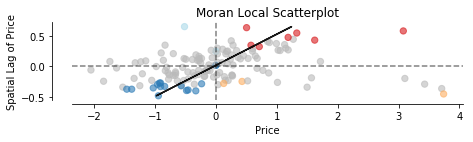

In [99]:
fig, ax = moran_scatterplot(li1, p=0.05)
ax.set_xlabel('Price')
ax.set_ylabel('Spatial Lag of Price')

### 局部莫兰指数对应的lisa聚类图

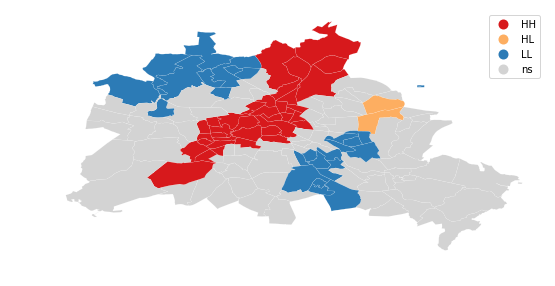

In [100]:
from splot.esda import lisa_cluster

lisa_cluster(li, df, p=0.05, figsize = (9,9))
plt.show()

(<Figure size 648x648 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x20ad410f9b0>)

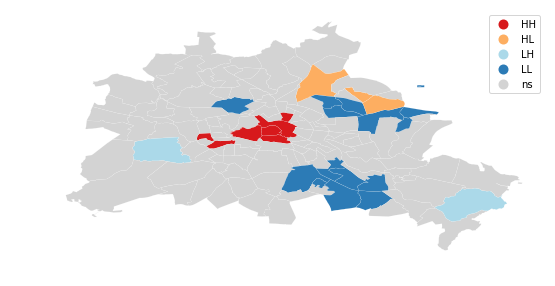

In [101]:
lisa_cluster(li1, df1, p=0.05, figsize = (9,9))